Using this pipeline https://smorabit.github.io/tutorials/8_velocyto/
Use different clustering numbers

In [1]:
#mount drive
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet
!pip install python-igraph
!pip install pybind11 hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 3.8 MB/s eta 0:00

In [49]:

#First, import required packages in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip freeze on 20230726

In [50]:
# load sparse matrix:
X = io.mmread("/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/counts.mtx")

In [51]:
# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

In [52]:
# load cell metadata:
cell_meta = pd.read_csv("/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/metadata.csv")

In [53]:
# load gene names:
with open("/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

In [54]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [55]:
# load dimensional reduction:
pca = pd.read_csv("/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/pca.csv")
pca.index = adata.obs.index

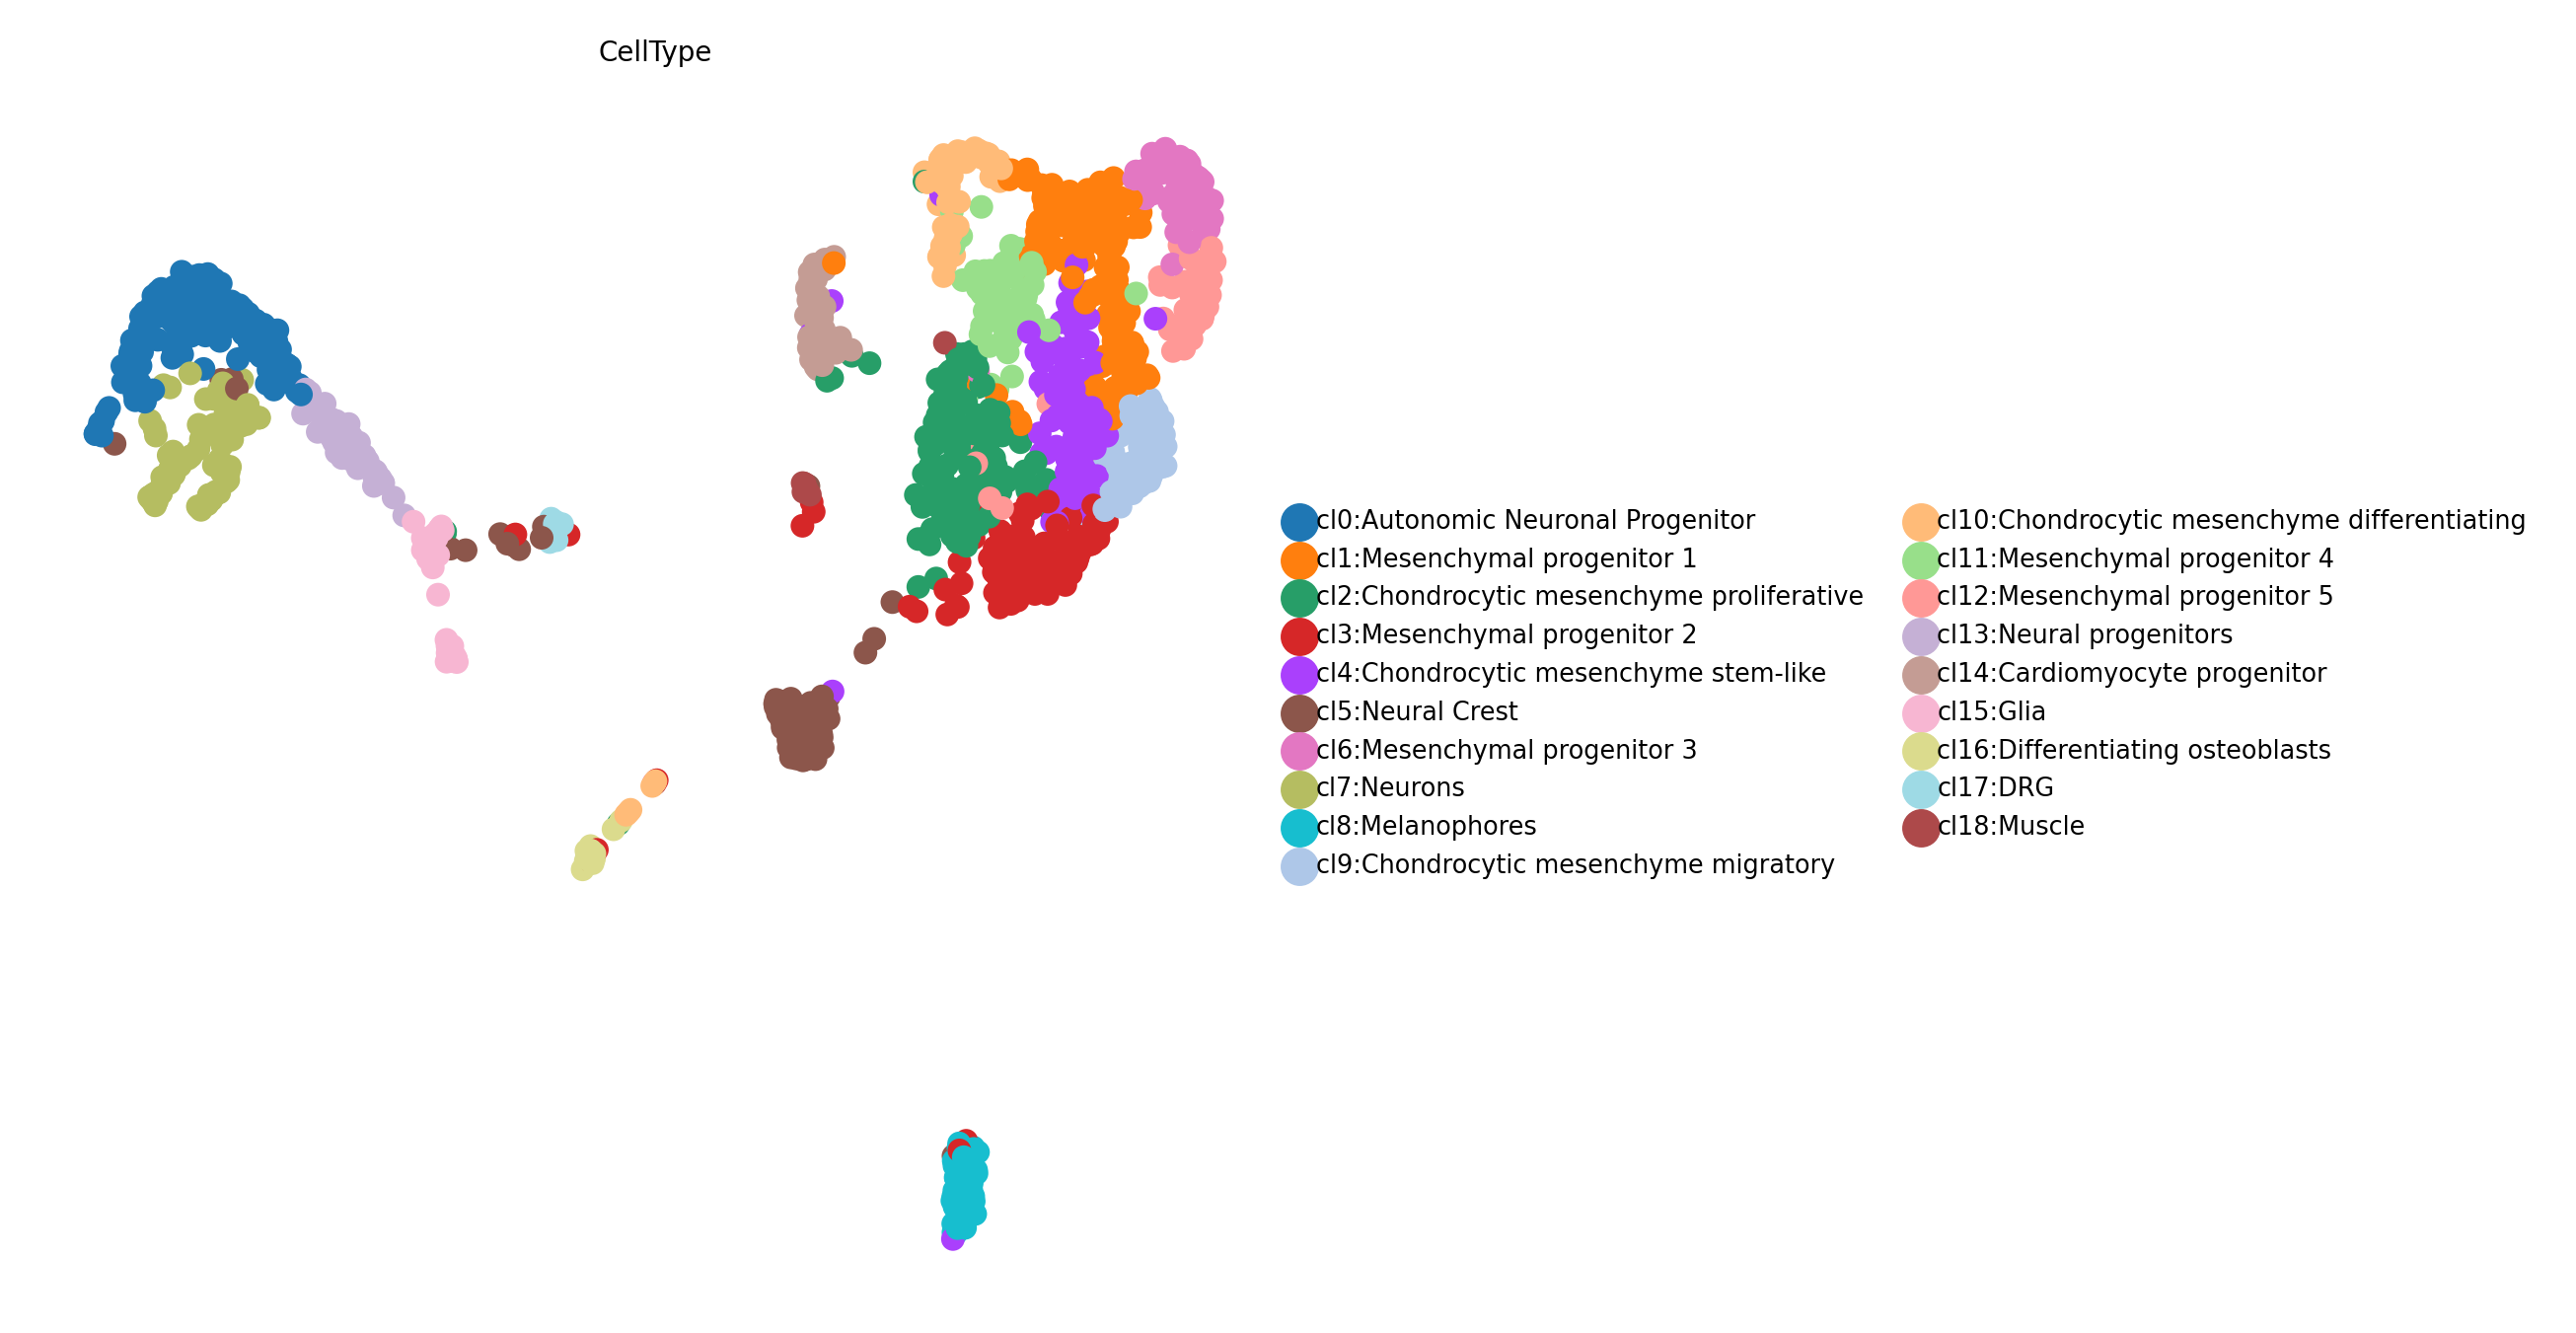

In [56]:
# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T


sc.pl.umap(adata, frameon=False, color="CellType")

# save dataset as anndata format
adata.write('/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/seurat_original_data_48HPF_v20230802.h5ad')



In [57]:
# reload dataset
adata = sc.read_h5ad('/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/seurat_original_data_48HPF_v20230802.h5ad')

In [ ]:
#shroter names to cluster
major_cell_type = [""]
adata.rename_categories('CellType', major_cell_type)

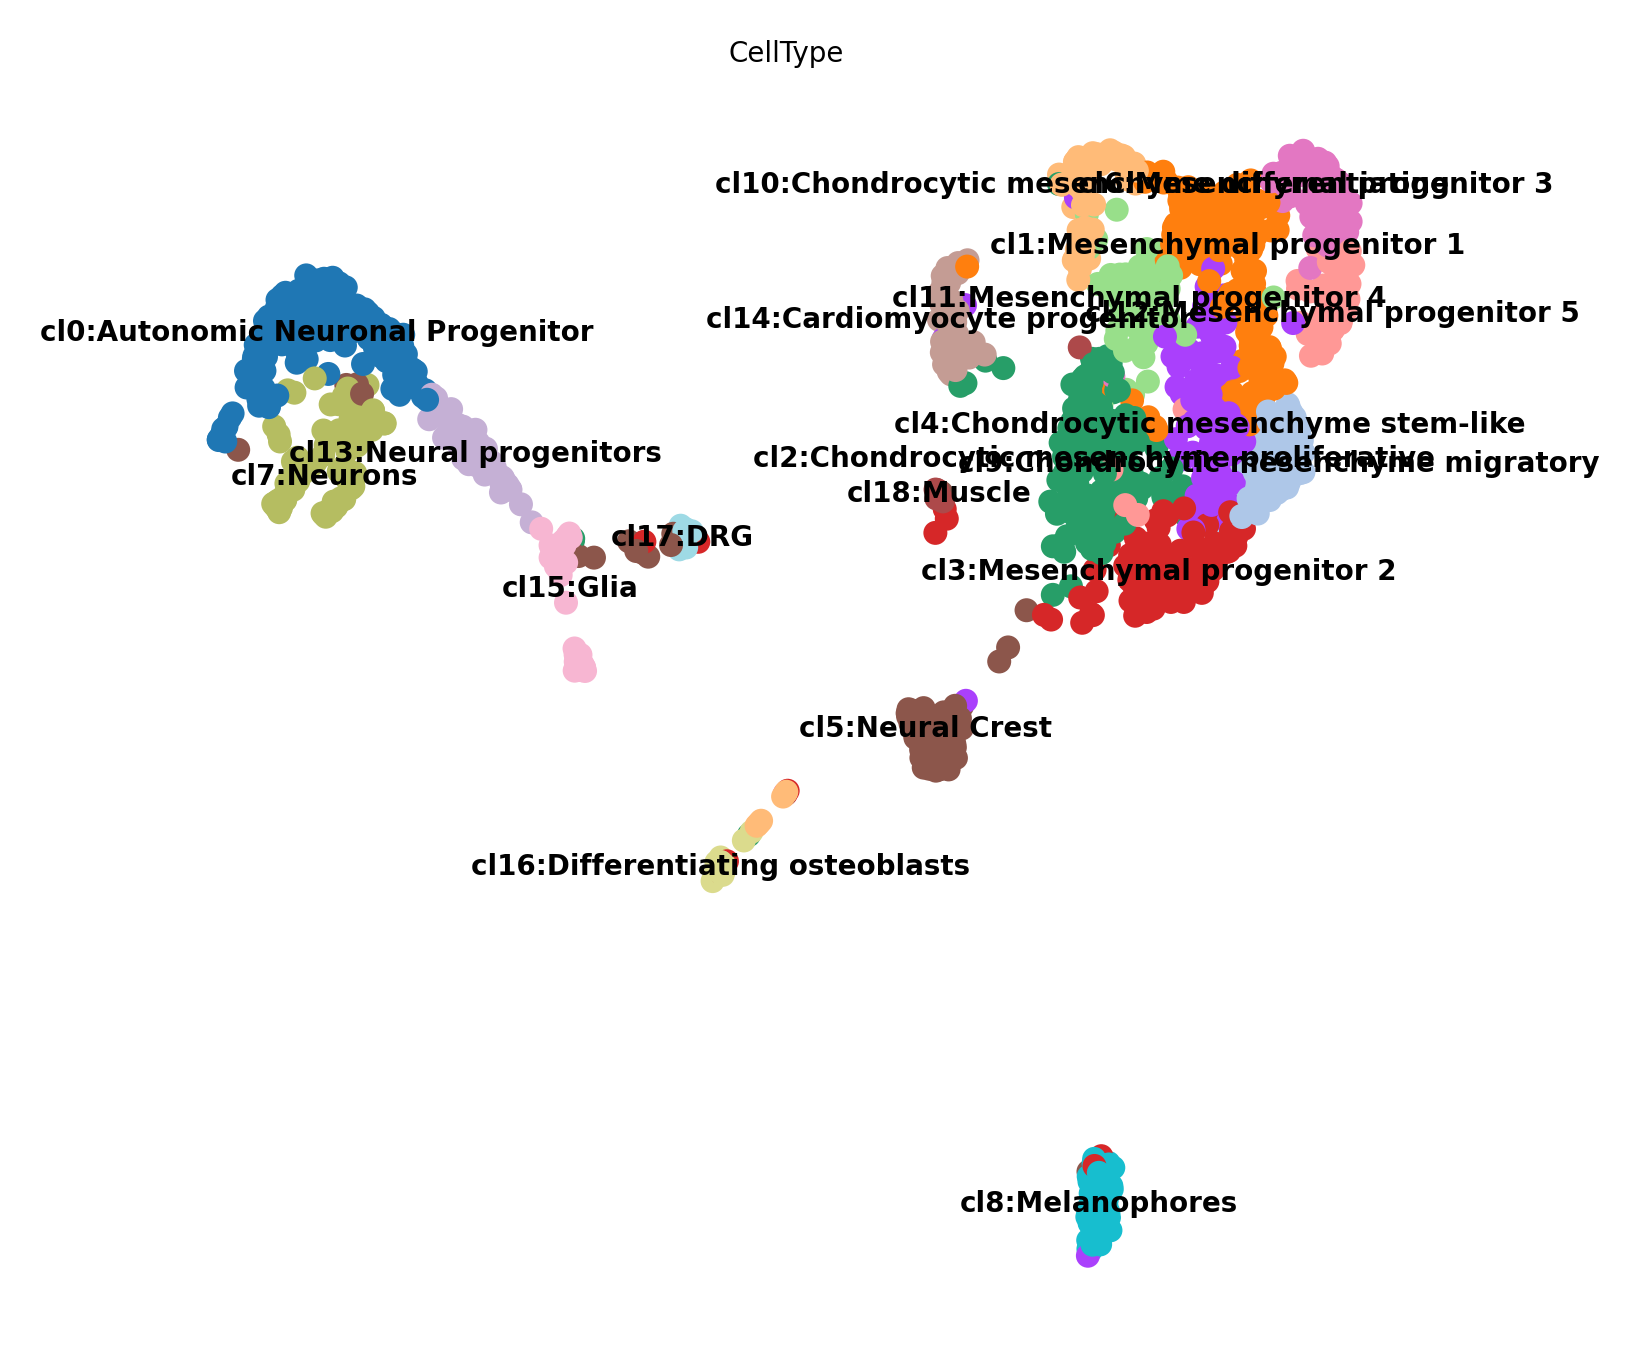

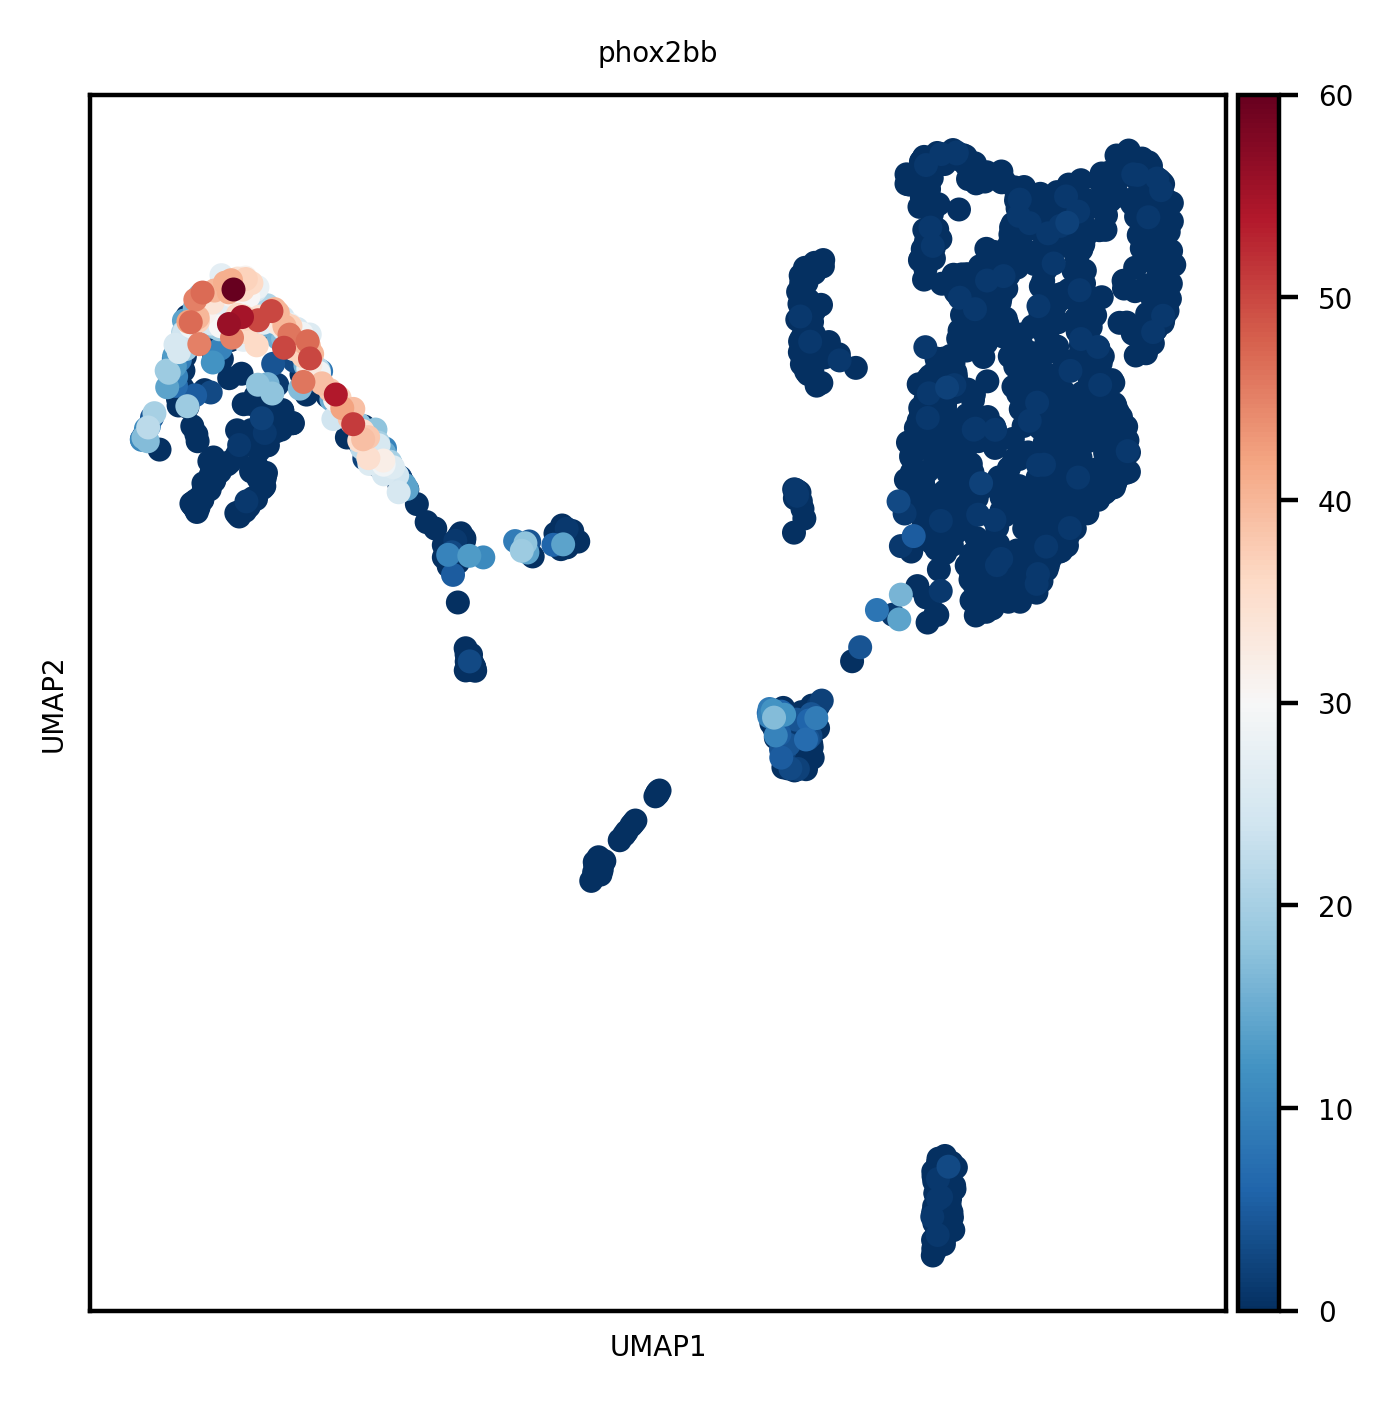

In [59]:
sc.set_figure_params(scanpy=True, fontsize=5, dpi=200)
sc.pl.umap(adata, frameon=False, color="CellType", legend_loc="on data")

sc.pl.umap(adata, color=['phox2bb'])

In [ ]:
# here, make a dot plot with the main markers to reproduce the elife paper figure

In [60]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.5 (python 3.10.12) on 2023-08-02 20:21.


In [61]:
adata

AnnData object with n_obs × n_vars = 1608 × 17677
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2'
    uns: 'CellType_colors'
    obsm: 'X_pca', 'X_umap'

In [62]:
# load loom files for spliced/unspliced matrices for each sample:
ldata1 = scv.read('/content/gdrive/MyDrive/singlecell_uribe/velocyto/sox10_48h_cellranger211_GRCZ10.loom')

In [63]:
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_10' for bc in barcodes]
ldata1.obs.index = barcodes

In [64]:
# make variable names unique
ldata1.var_names_make_unique()

In [65]:
# merge matrices into the original adata object

adata = scv.utils.merge(adata, ldata1, id_length=10)


In [66]:
adata

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 1604 × 14396
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'CellType_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

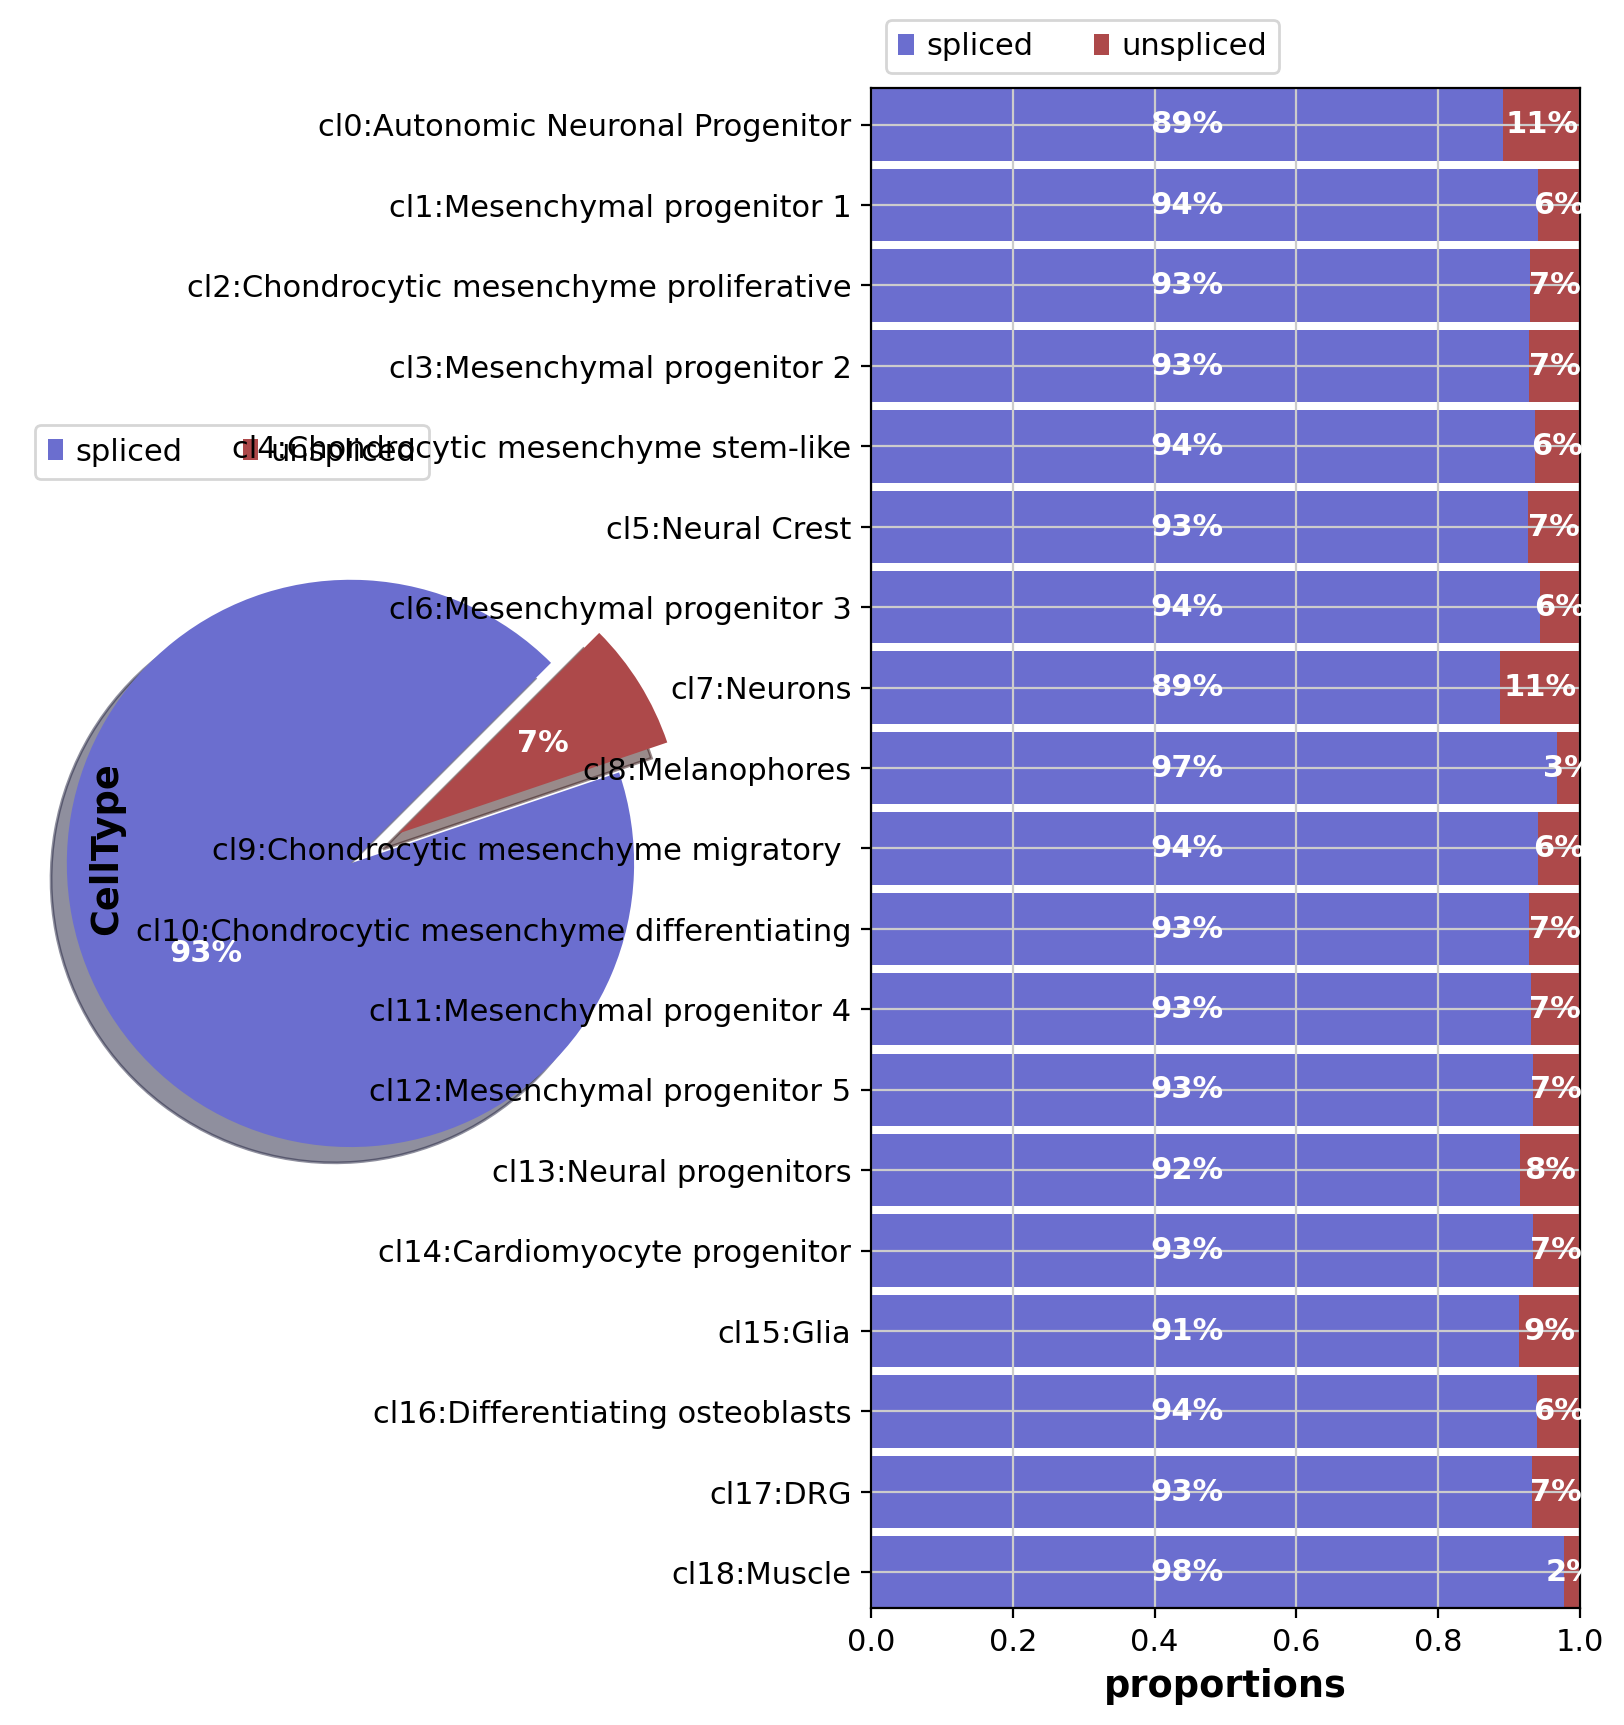

In [67]:
scv.pl.proportions(adata, groupby='CellType', figsize=(10, 10), fontsize=11)

In [68]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=20, n_neighbors=50)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [69]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/2 cores)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3178 [00:00<?, ?gene/s]

    finished (0:18:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [70]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/1604 [00:00<?, ?cells/s]

    finished (0:00:48) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


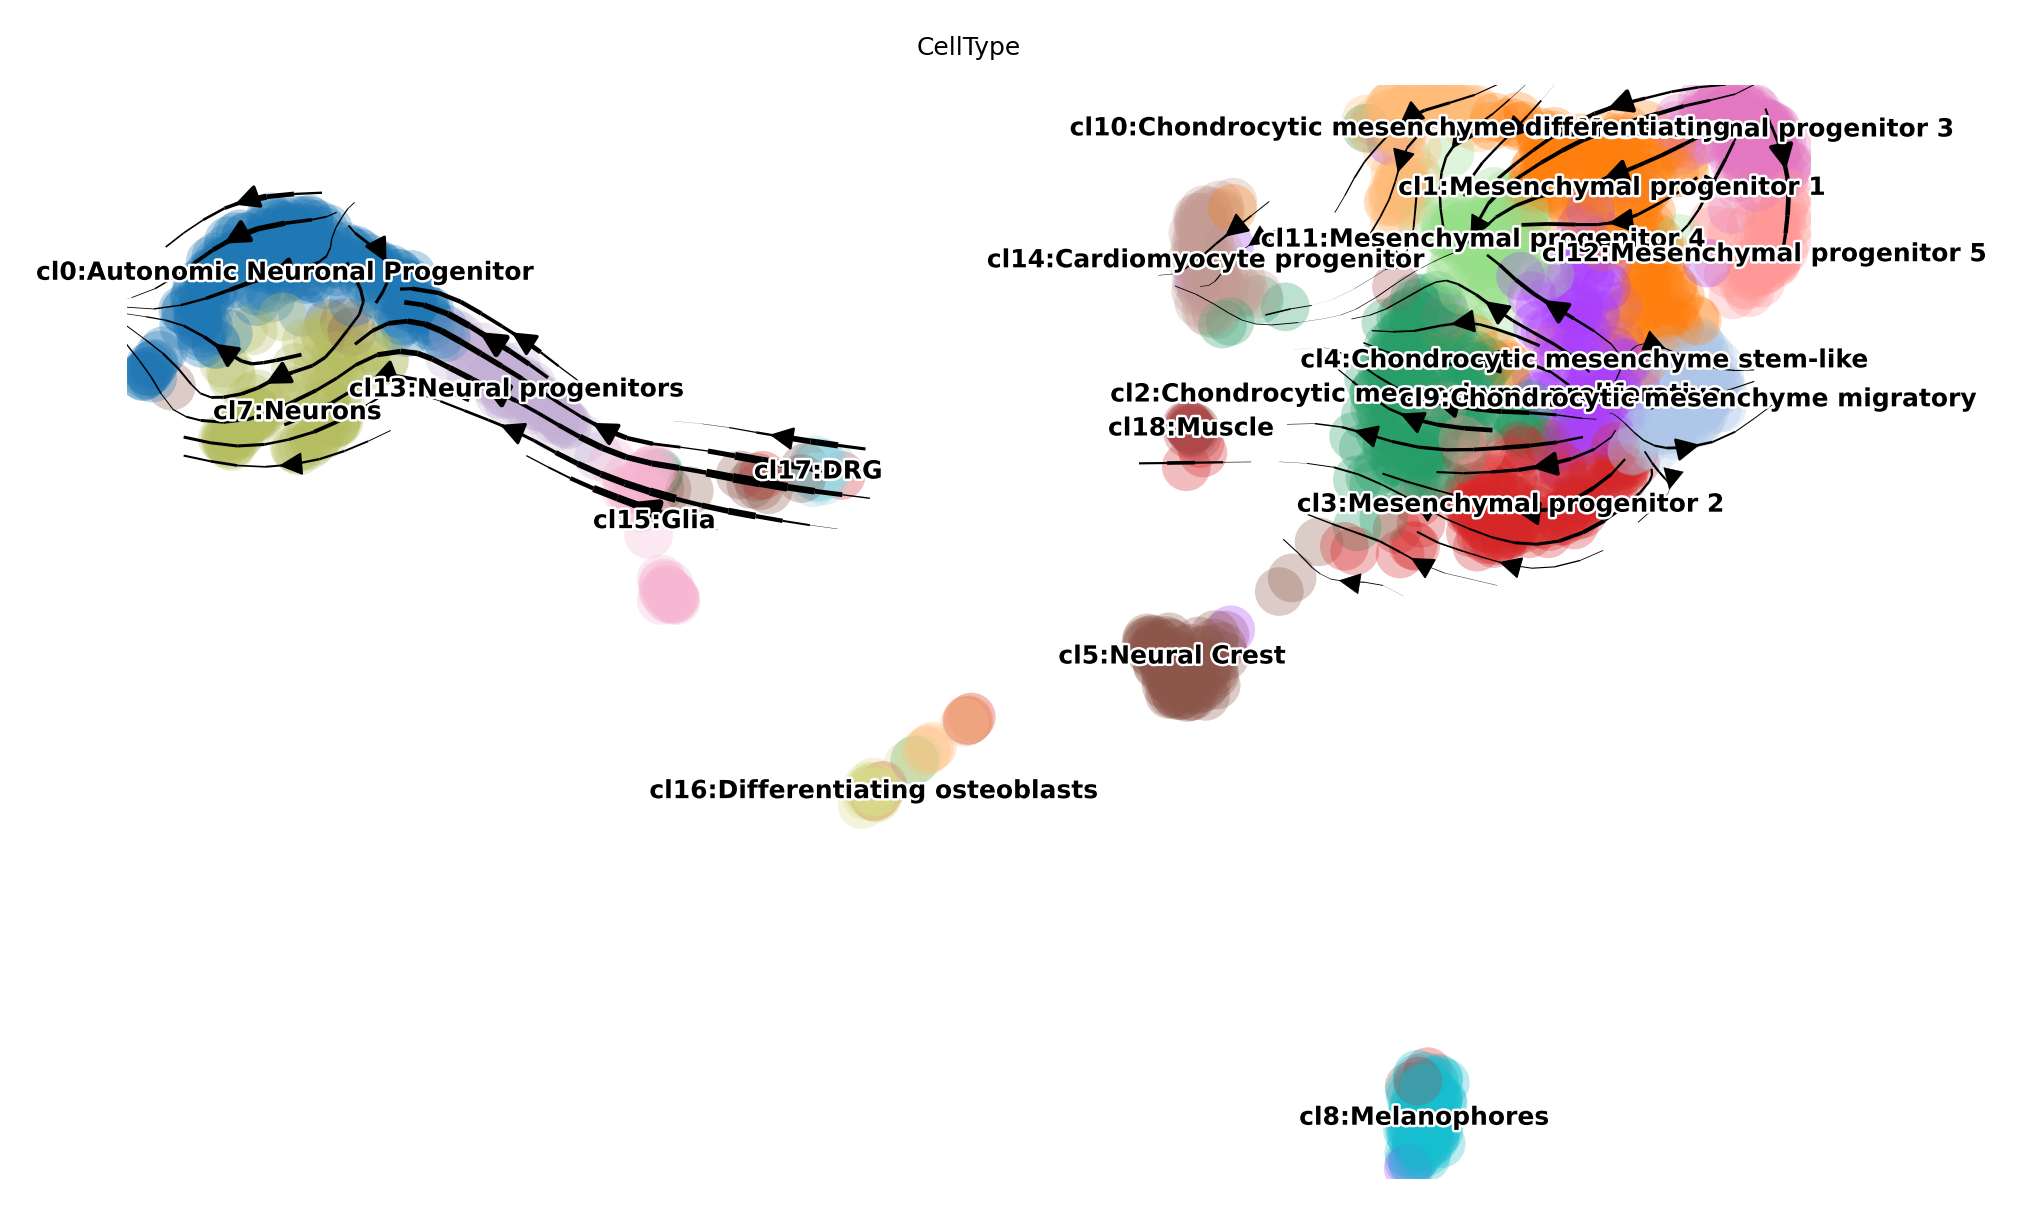

In [71]:
scv.set_figure_params('scvelo', fontsize=5, dpi=180)
scv.pl.velocity_embedding_stream(adata, basis='umap', color='CellType')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


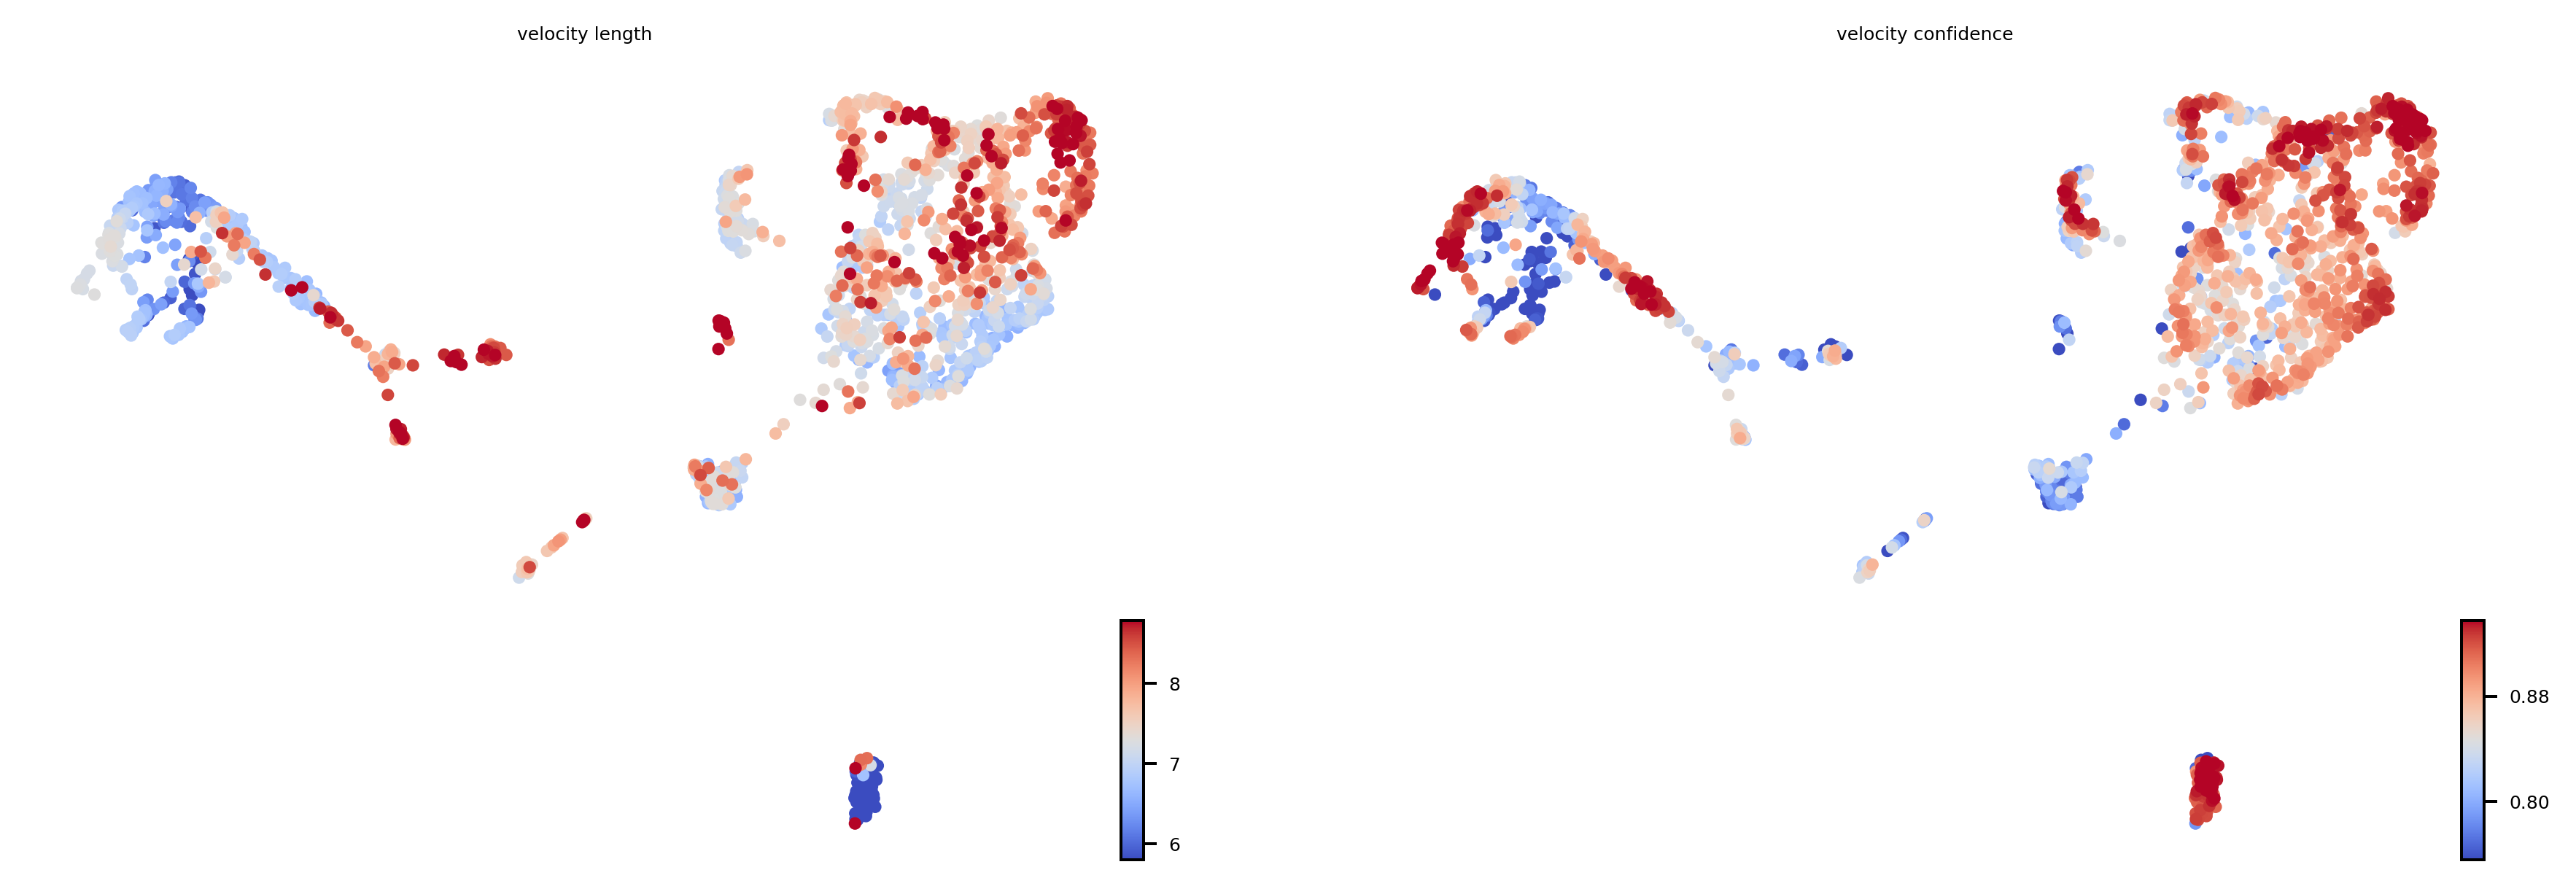

In [72]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


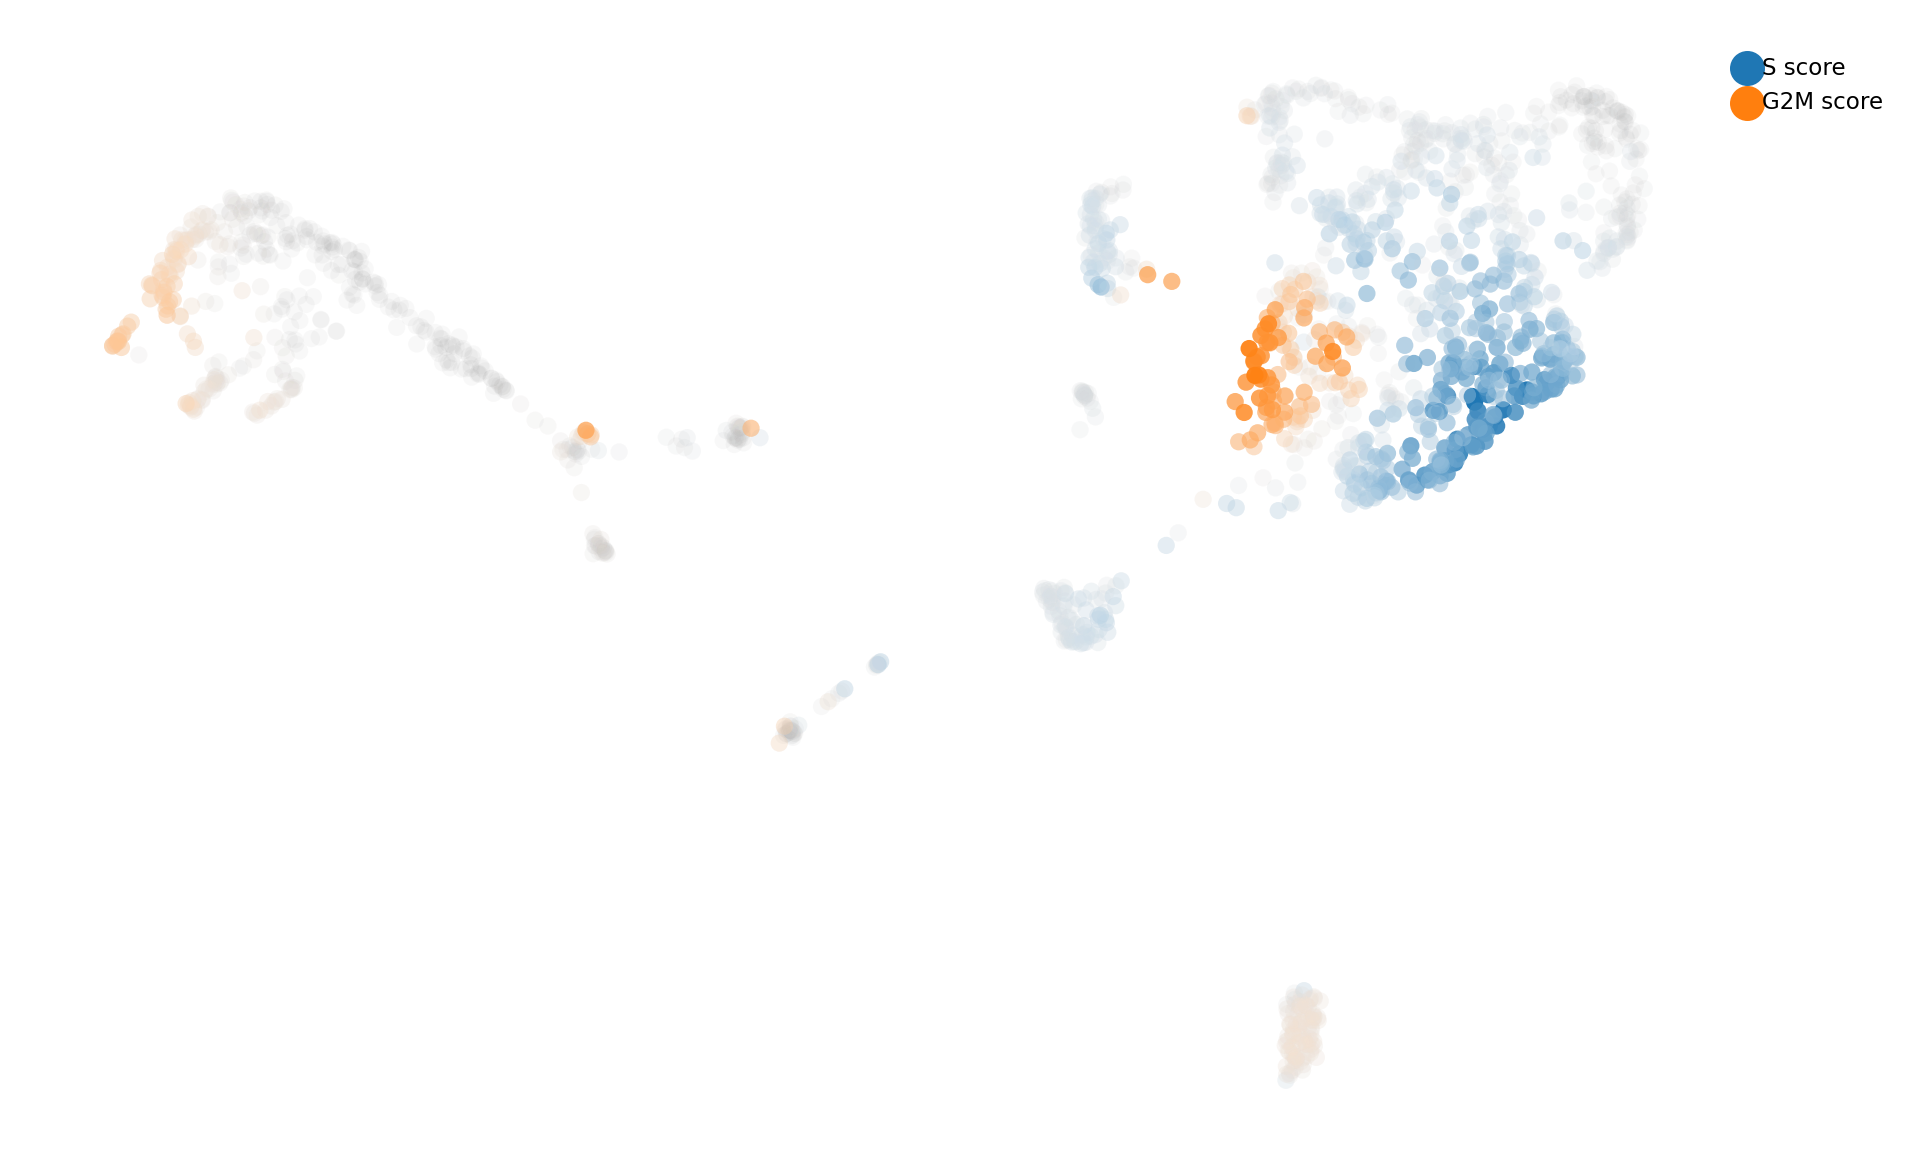

In [73]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

In [74]:
scv.tl.rank_velocity_genes(adata, groupby='CellType', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


ranking velocity genes
    finished (0:00:12) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


<ipython-input-74-91643fd6e293>:3: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])


cl0:Autonomic Neuronal Progenitor cl1:Mesenchymal progenitor 1  \
0                            nrn1la                         emp2   
1                        kiaa1549la                         jupa   
2                            nlgn3b                         fen1   
3                          cacna1aa                       sept7b   
4                            scn8aa                        tdg.1   

  cl2:Chondrocytic mesenchyme proliferative cl3:Mesenchymal progenitor 2  \
0                                    ralbp1                        luc7l   
1                                   col5a3a                      tmem176   
2                                    fam49a                      fam60al   
3                                     sfrp5                        cebpg   
4                                     rab6a                        ccar1   

  cl4:Chondrocytic mesenchyme stem-like  cl5:Neural Crest  \
0                                   dcn  si:dkey-250k10.4   
1                               olfml3b             vamp5   
2                                oscp1a           pik3r3b   
3                               tmem45a              dvl2   
4                                ccdc6a        zgc:154075   

  cl6:Mesenchymal progenitor 3 cl7:Neurons cl8:Melanophores  \
0                       cxxc1a      grin1a           ndufb8   
1                         p3h1     znf385c            tomm6   
2                         ctc1       dab1a             mtpn   
3                        baz1b       ptpn5            rpl14   
4                         jupa     tmem63c           atp5f1   

  cl9:Chondrocytic mesenchyme migratory   \
0                                   mlh1   
1                                eif2s1b   
2                                  wdr75   
3                                   slka   
4                                 smad6a   

  cl10:Chondrocytic mesenchyme differentiating cl11:Mesenchymal progenitor 4  \
0                                        fbxl6                         nop58   
1                                       heatr1                          ebf2   
2                                        etf1b                          pax9   
3                                        ttll4             si:ch211-147a11.3   
4                                         ebf2                        trip11   

  cl12:Mesenchymal progenitor 5 cl13:Neural progenitors  \
0                         kpnb3                    atl1   
1                           dck                  fxyd6l   
2                         hvcn1                 st8sia5   
3                     dnmt3bb.1                  ctnna2   
4                       igf2bp1                  gnao1a   

  cl14:Cardiomyocyte progenitor cl15:Glia cl16:Differentiating osteoblasts  \
0                        adrb3a     phgdh                          col11a2   
1                          pora     ntn1b                              emd   
2                         rdh12    ctnna2                          col5a3a   
3                        sec61b      dvl2                            stk10   
4                         CDPF1   sh2d3ca                             lef1   

  cl17:DRG cl18:Muscle  
0     aig1       tia1l  
1   ctnna2      fam32a  
2   elavl4       calua  
3      smo     pcdh18a  
4   kif1aa  zgc:110224

In [75]:
# save dataset as anndata format
adata.write('/content/gdrive/MyDrive/singlecell_uribe/48h_Uribe_original_metadata/seurat_original_data_48HPF_v20230802.h5ad')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
adata

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 1604 × 14396
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'S_score', 'G2M_score', 'phase', 'clusters_gradients'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'CellType_colors', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'clusters_gradients_colors', 'rank_velocit

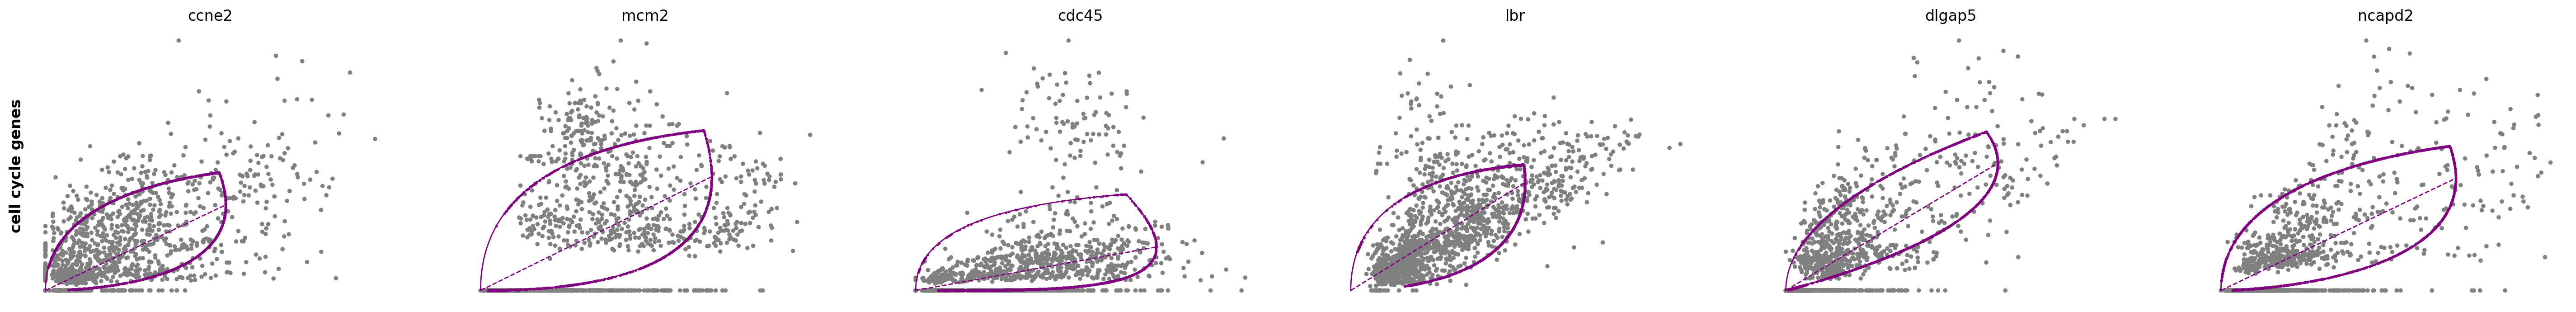

In [77]:
scv.set_figure_params('scvelo')
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:3]) + list(g2m_genes[:3]), **kwargs)

In [ ]:
#make a list of all these cell cycle markers markers https://cdn.elifesciences.org/articles/60005/elife-60005-fig1-figsupp3-v1.jpg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


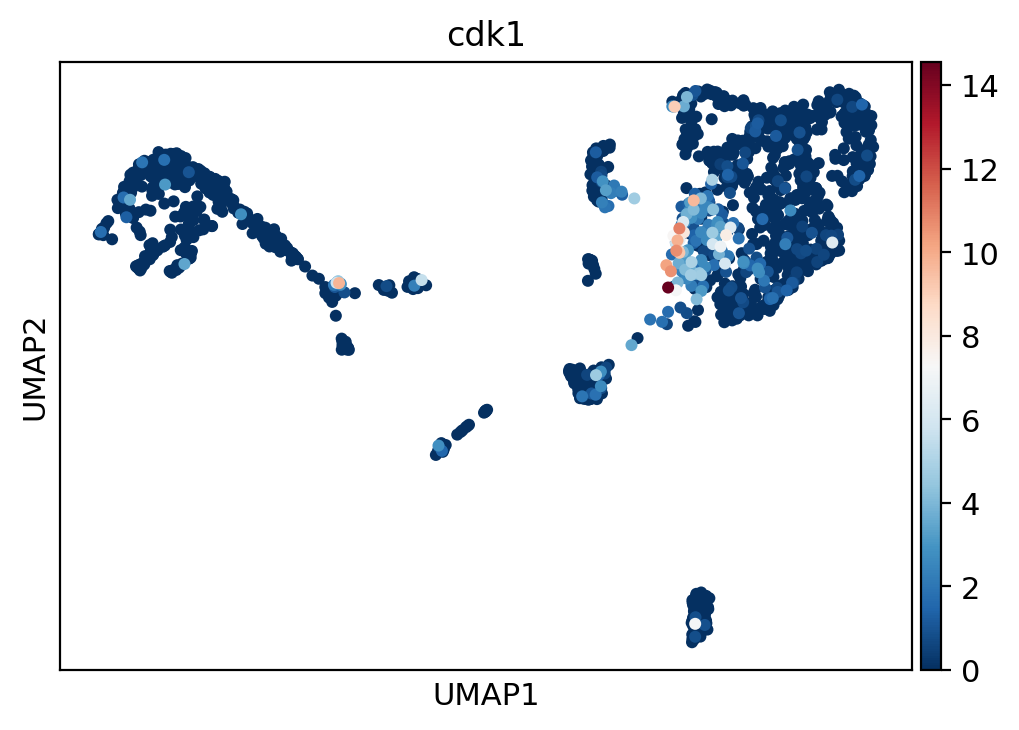

/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


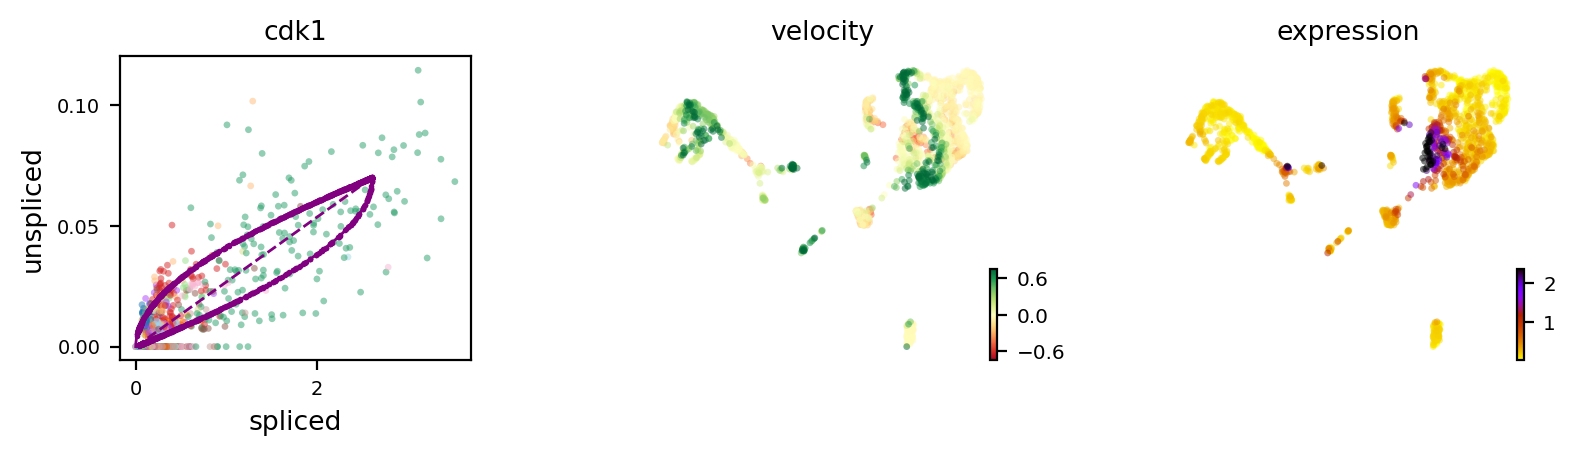

In [78]:

sc.pl.umap(adata, color=['cdk1'])
scv.pl.velocity(adata, var_names=['cdk1'], color='CellType')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


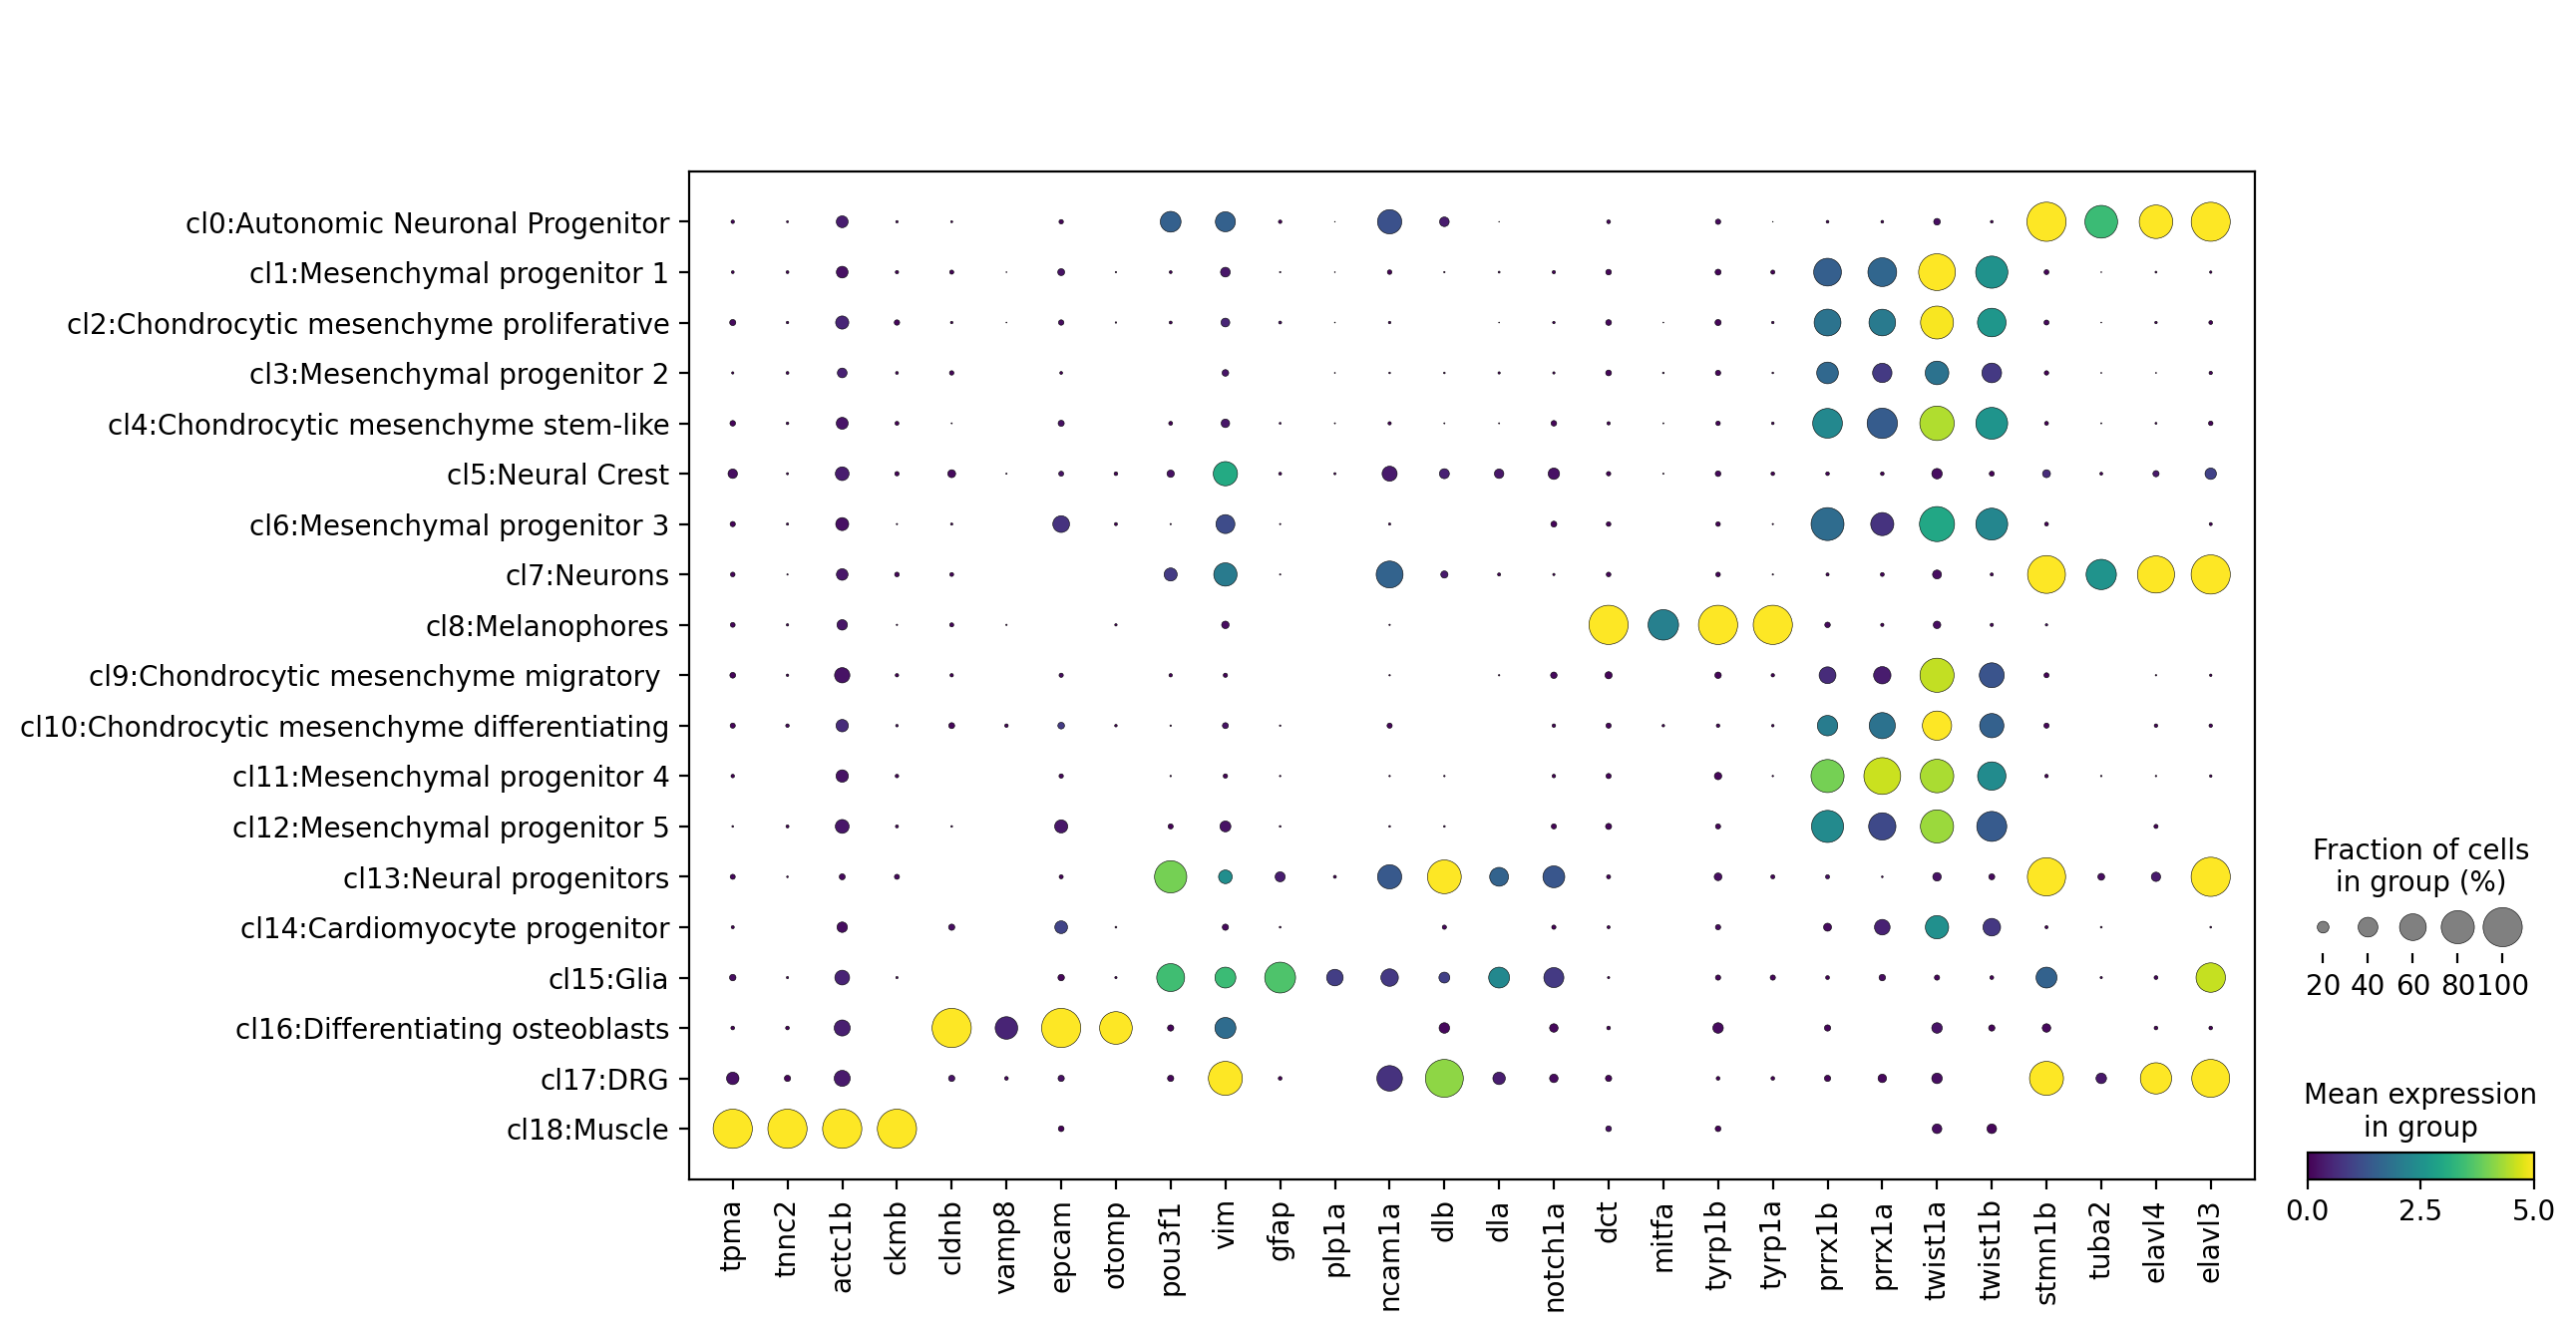

In [79]:
var_names=['tpma', 'tnnc2', 'actc1b', 'ckmb', 'cldnb', 'vamp8','epcam', 'otomp', 'pou3f1', 'vim', 'gfap', 'plp1a', 'ncam1a', 'dlb', 'dla', 'notch1a', 'dct', 'mitfa', 'tyrp1b', 'tyrp1a', 'prrx1b', 'prrx1a', 'twist1a', 'twist1b', 'stmn1b', 'tuba2', 'elavl4', 'elavl3']

sc.pl.dotplot(adata, var_names=var_names, groupby='CellType', cmap= 'viridis', vmin=0, vmax=5 )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


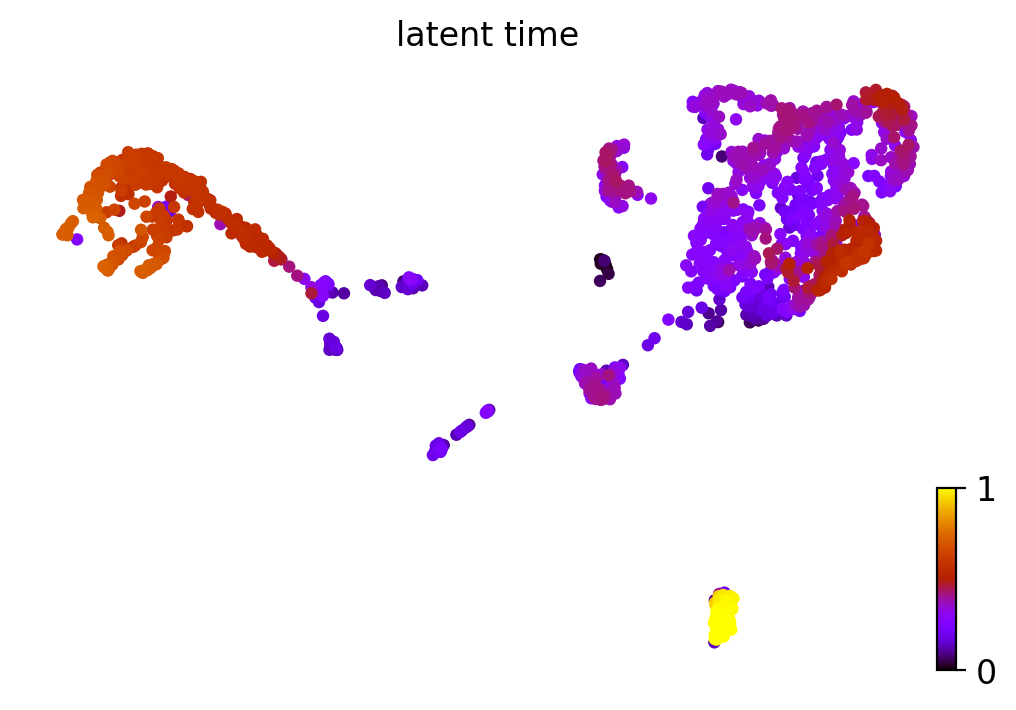

In [80]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80, colorbar=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


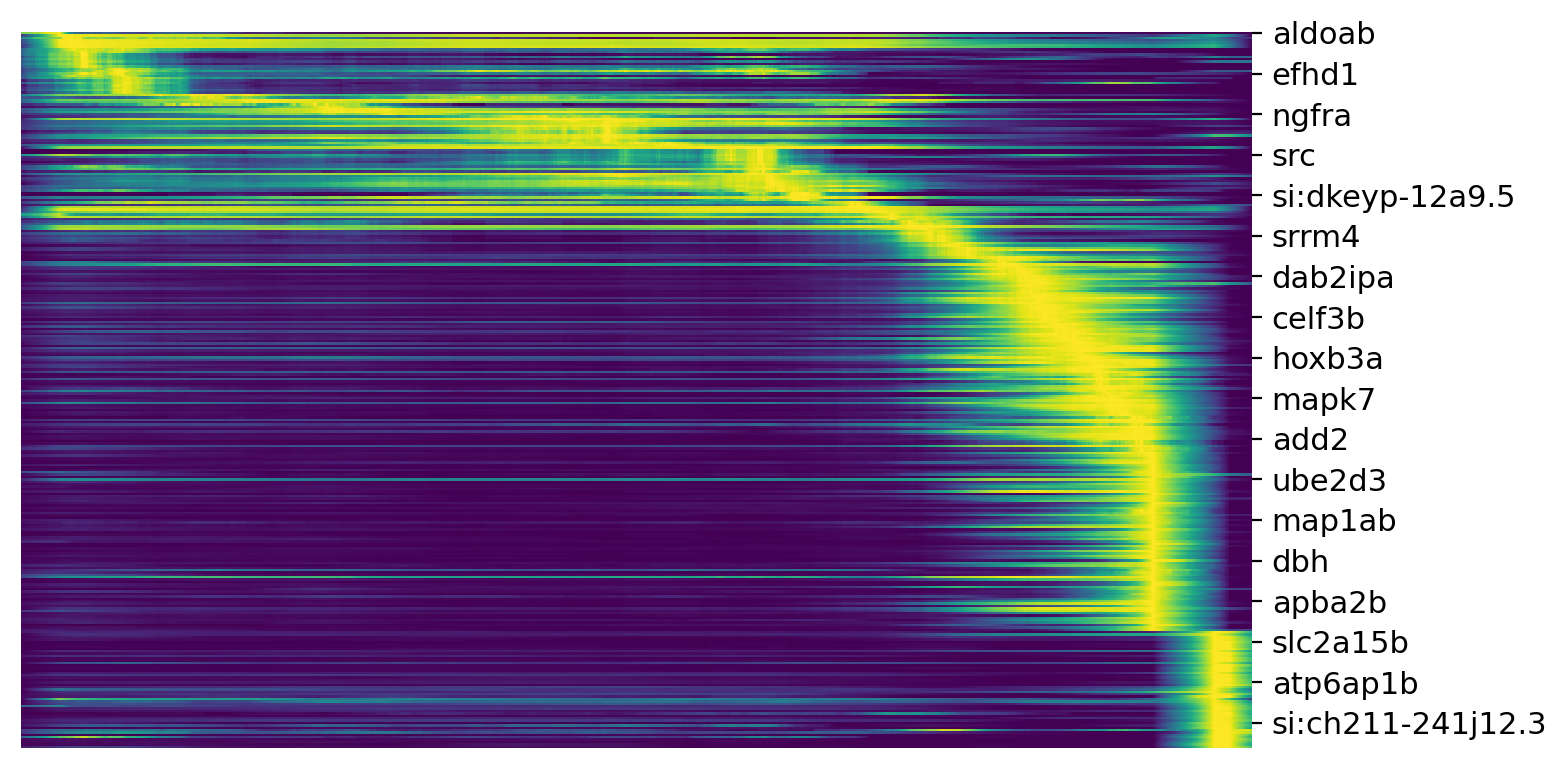

In [81]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes,tkey='latent_time', n_convolve=100)

In [ ]:
!pip freeze > scvelo_google_colab_package_versions.txt